In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib_venn import *
from pyBioInfo.IO.File import GtfFile, GtfGeneBuilder, GtfTranscriptBuilder
from pyBioInfo.Utils import ShiftLoader

# Gene overlap

In [178]:
genes_ncbi= []
with GtfFile("../../common/ncbi_Sdu_1.0/GCF_002260705.1_Sdu_1.0_genomic.clean.sorted.gtf.gz") as f:
    records = [x for x in f]
for record in records:
    genes_ncbi.append(record.attributes["gene_id"])
genes_ncbi = set(genes_ncbi)

In [179]:
dat = pd.read_csv("../../3_integrate_isoforms/results/assembly/sqanti3/ncbi_vs_asm/query_classification.txt", sep="\t")
genes_assembly = set(dat["associated_gene"])

In [180]:
genes_common = genes_ncbi & genes_assembly
genes_ncbi_only = genes_ncbi - genes_common
genes_assembly_only = genes_assembly - genes_common

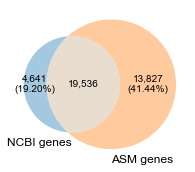

In [181]:
a = len(genes_ncbi_only)
b = len(genes_common)
c = len(genes_assembly_only)
plt.figure(figsize=(3, 2.5))
v = venn2(subsets=(a, b, c), set_labels=["NCBI genes", "ASM genes"], set_colors=["C0", "C1"])
v.get_label_by_id('10').set_text(format(a, ",") + "\n(%.2f%%)" % (a * 100 / len(genes_ncbi)))
v.get_label_by_id('11').set_text(format(b, ","))
v.get_label_by_id('01').set_text(format(c, ",") + "\n(%.2f%%)" % (c * 100 / len(genes_assembly)))
plt.tight_layout()
plt.savefig("figures/genes_overlap.pdf", dpi=300)

# Gene feature

In [2]:
with GtfFile("../../common/ncbi_Sdu_1.0/GCF_002260705.1_Sdu_1.0_genomic.clean.sorted.gtf.gz") as f:
    records = [x for x in f]
ncbi_genes = list(sorted(GtfGeneBuilder(records)))
for g in ncbi_genes:
    g.length = max([len(t) for t in g.transcripts])
print(len(ncbi_genes))

23878


In [8]:
with GtfFile("../../3_integrate_isoforms/results/assembly/asm.final.sorted.gtf.gz") as f:
    records = [x for x in f]
asm_genes = list(sorted(GtfGeneBuilder(records)))
for g in asm_genes:
    g.length = max([len(t) for t in g.transcripts])
    counter = defaultdict(int)
    for t in g.transcripts:
        tid = t.records["transcript"][0].attributes["transcript_id"]
        if tid.startswith("G"):
            counter["TGS"] += 1
        elif tid.startswith("MSTRG"):
            counter["NGS"] += 1
        else:
            assert False
    g.sources = counter
print(len(asm_genes))

33363


In [9]:
ncbi_fpkms = dict(pd.read_csv("../../3_integrate_isoforms/results/expression/stringtie/ncbi.gene_abund.tsv", sep="\t", index_col=0).max(axis=1))
asm_fpkms = dict(pd.read_csv("../../3_integrate_isoforms/results/expression/stringtie/asm.gene_abund.tsv", sep="\t", index_col=0).max(axis=1))

In [10]:
def seperate_hit_genes(genes1, genes2):
    loader = ShiftLoader(genes2)
    array1 = []
    array2 = []
    for gene1 in genes1:
        hit = False
        for gene2 in loader.fetch(obj=gene1):
            if gene2.strand == gene1.strand:
                hit = True
                break
        if hit:
            array1.append(gene1)
        else:
            array2.append(gene1)
    return array1, array2

ncbi_hit_genes, ncbi_not_hit_genes = seperate_hit_genes(ncbi_genes, asm_genes)
asm_hit_genes, asm_not_hit_genes = seperate_hit_genes(asm_genes, ncbi_genes)

In [11]:
asm_hit_ngs_genes = []
asm_hit_tgs_genes = []
for g in asm_hit_genes:
    if g.sources["TGS"] > 0:
        asm_hit_tgs_genes.append(g)
    else:
        asm_hit_ngs_genes.append(g)
print(len(asm_hit_ngs_genes), len(asm_hit_tgs_genes))

asm_not_hit_ngs_genes = []
asm_not_hit_tgs_genes = []
for g in asm_not_hit_genes:
    if g.sources["TGS"] > 0:
        asm_not_hit_tgs_genes.append(g)
    else:
        asm_not_hit_ngs_genes.append(g)
print(len(asm_not_hit_ngs_genes), len(asm_not_hit_tgs_genes))

3978 18046
7914 3425


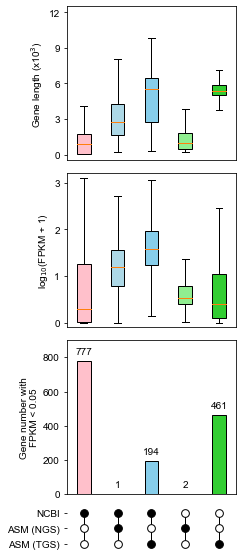

In [24]:
array = [ncbi_not_hit_genes, asm_hit_ngs_genes, asm_hit_tgs_genes, asm_not_hit_ngs_genes, asm_not_hit_tgs_genes]

w = 0.4
colors = ['pink', 'lightblue', 'skyblue', 'lightgreen', 'limegreen']

fig = plt.figure(figsize=(3.5, 7.7))
gs = GridSpec(10, 1, figure=fig, hspace=0.3, left=0.28, right=0.95, bottom=0.01, top=0.99)

ax1 = fig.add_subplot(gs[:3, 0])
plt.sca(ax1)
for i, genes in enumerate(array):
    lengths = [g.length/1e3 for g in genes]
    bplot = plt.boxplot([lengths], positions=[i], widths=w, showfliers=False, patch_artist=True)
    for j, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(colors[i])
plt.xticks([])
plt.ylim(-0.5, 12.5)
plt.yticks([0, 3, 6, 9, 12])
plt.ylabel("Gene length (x10$^3$)")

ax2 = fig.add_subplot(gs[3:6, 0])
plt.sca(ax2)
low_fpkm_gene_counts = []
for i, genes in enumerate(array):
    fpkms = np.array([ncbi_fpkms[g.name] if g.name in ncbi_fpkms else asm_fpkms[g.name] for g in genes])
    low_fpkm_gene_counts.append(sum(fpkms < 0.05))
    fpkms = np.log10(1 + fpkms)
    bplot = plt.boxplot([fpkms], positions=[i], widths=w, showfliers=False, patch_artist=True)
    for j, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(colors[i])
plt.xticks([])
plt.ylim(-0.1, 3.2)
plt.yticks([0, 1, 2, 3])
plt.ylabel("log$_{10}$(FPKM + 1)")
    
ax3 = fig.add_subplot(gs[6:9, 0])
plt.sca(ax3)
ys = low_fpkm_gene_counts
xs = np.arange(len(ys))
plt.bar(xs, ys, width=w, edgecolor="black", color=colors)
for x, y in zip(xs, ys):
    plt.text(x, y + max(ys) * 0.05, str(y), ha="center")
plt.xticks([])
plt.ylim(0, 900)
plt.ylabel("Gene number with\nFPKM < 0.05")

ax4 = fig.add_subplot(gs[-1:, 0])
plt.sca(ax4)

mtx = [
    [1, 1, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 1]
]

for x in range(len(mtx[0])):
    plt.plot([x, x], [0, 2], lw=1, color="black")
    for y in range(len(mtx)):
        color = "white" if mtx[y][x] == 0 else "black"
        plt.scatter(x, y, marker="o", s=60, edgecolor="black", color=color, zorder=10)
plt.yticks([0, 1, 2], ["NCBI", "ASM (NGS)", "ASM (TGS)"])
plt.ylim(2.4, -0.4)
for k, v in plt.gca().spines.items():
    v.set_visible(False)
plt.xticks([])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(-0.5, 4.5)

# plt.tight_layout(rect=(0, 0, 1, 1))
plt.savefig("figures/gene_feature.pdf", dpi=300)